In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BSSSBSBS'
meas='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])
#sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])


from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+---------+------+--------------------+------+
|-1622.7998052240664|-322.63234835418984|-2.1238916653613877|     25.9|BSSSBSBS| 31.0583|  -87.055|       PRCP| 0.4327306727380128| 0.4112932029938387| 0.4113075539483236|0.8630642248402041|USC00011084|5728945.0|     4|[00 00 00 00 00 0...|2009.0|
| 438.18

### Plot Mean and Eigenvecs

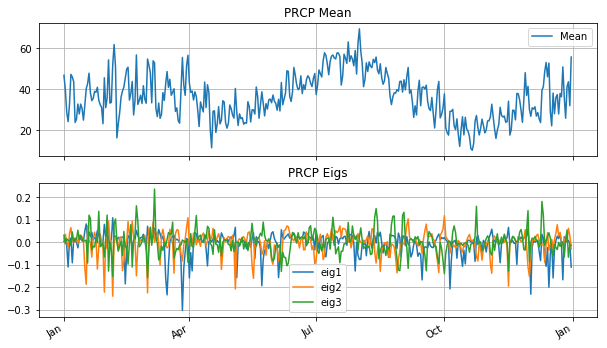

In [7]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

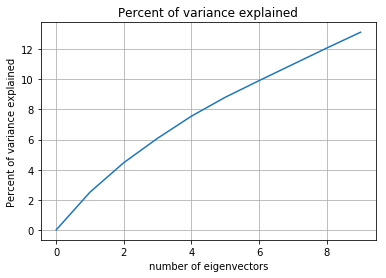

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [9]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

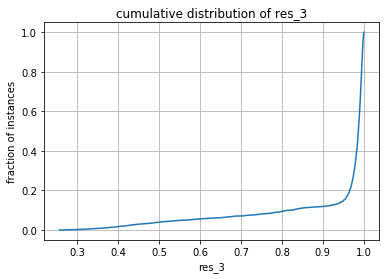

In [10]:
plot_CDF(df,'res_3')

In [11]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00011084', 2009.0)

In [12]:
days=set([r[1] for r in rows])
miny=min(days)
print miny
maxy=max(days)
print maxy
record_len=int((maxy-miny+1)*365)
record_len

1890.0
2012.0


44895

In [13]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [14]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [15]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

US1ALBW0031 1728
US1ALBW0030 1703
US1FLOK0026 317
US1ALBW0032 321
US1FLOK0020 1282
US1FLOK0023 1762
US1ALBW0039 1442
US1ALBW0038 1023
US1FLOK0029 1453
US1ALMB0049 1663
USC00012670 3216
US1ALMB0041 999
US1ALMB0042 338
USC00010402 17194
US1ALMB0044 1035
USC00228382 6855
USC00010407 4293
US1ALMB0047 1433
USW00053843 1337
USW00063870 1038
US1ALMB0017 329
USC00014822 9387
USC00015842 696
USC00086129 3074
USC00014431 11972
US1FLES0013 708
US1ALCF0004 1050
US1FLES0010 1755
US1FLES0017 321
US1FLES0015 1067
US1ALBW0026 1413
US1ALBW0027 1404
USC00081299 1060
USC00016937 15956
USW00093859 5076
USC00011566 20354
USW00013899 23156
USC00010252 25449
USC00012577 25642
US1FLWT0014 344
USC00089206 6357
USC00012172 12780
USC00012675 13231
USC00226054 338
US1FLWT0013 724
USW00093826 1813
US1ALDL0001 1336
US1FLOK0024 1776
US1FLES0002 1776
USW00003855 21536
US1FLWT0005 1662
US1FLES0005 1365
USW00093828 1788
US1FLWT0006 988
USW00093841 19677
USC00012813 26435
USW00063899 1788
USC00226790 680
US1ALBW0053 129

In [16]:
rows=df.rdd.map(lambda row:(row.station,row.latitude, row.longitude,unpackArray(row['vector'],np.float16))).collect()

In [17]:
import pandas as pd

In [18]:
data=pd.DataFrame(rows, columns=['station','latitude','longitude','vector'])
data=data.drop('vector',1)

In [19]:
data=data.drop_duplicates()

In [20]:
data=data.sort_values(by=['station'], ascending=True)

In [21]:
stations_1=data.iloc[0:21]
stations_2=data.iloc[90:101]
stations_3=pd.concat([stations_1,stations_2])
stations_3

,station,latitude,longitude
45,US1ALBW0001,30.5483,-87.8887
105,US1ALBW0003,30.6424,-87.9076
11,US1ALBW0004,30.6220,-87.9014
200,US1ALBW0005,30.2902,-87.5099
19,US1ALBW0008,30.3439,-87.7848
69,US1ALBW0009,30.4030,-87.6766
7,US1ALBW0011,30.2968,-87.5425
142,US1ALBW0013,30.5667,-87.9005
158,US1ALBW0019,30.3876,-87.4666
16,US1ALBW0026,30.6216,-87.7578


In [22]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [23]:
min_lat,max_lat,min_long,max_long = box = (30.2333, 30.6839,  -88.0, -87.41)

In [24]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in stations_3.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    #_count=row['count(station)']
    #_coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(6+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4)
    circles.append(c)
    m.add_layer(c)
m    

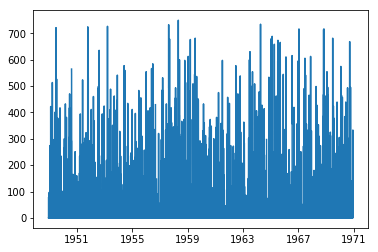

In [25]:
plot(dates,All['USW00013846']);

In [26]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(171, 44895)


In [27]:
Stations

[u'US1ALBW0001',
 u'US1ALBW0003',
 u'US1ALBW0004',
 u'US1ALBW0005',
 u'US1ALBW0008',
 u'US1ALBW0009',
 u'US1ALBW0011',
 u'US1ALBW0013',
 u'US1ALBW0019',
 u'US1ALBW0026',
 u'US1ALBW0027',
 u'US1ALBW0030',
 u'US1ALBW0031',
 u'US1ALBW0032',
 u'US1ALBW0038',
 u'US1ALBW0039',
 u'US1ALBW0040',
 u'US1ALBW0041',
 u'US1ALBW0045',
 u'US1ALBW0053',
 u'US1ALBW0054',
 u'US1ALBW0058',
 u'US1ALBW0059',
 u'US1ALCF0004',
 u'US1ALDL0001',
 u'US1ALES0001',
 u'US1ALHS0006',
 u'US1ALMB0001',
 u'US1ALMB0004',
 u'US1ALMB0010',
 u'US1ALMB0011',
 u'US1ALMB0014',
 u'US1ALMB0015',
 u'US1ALMB0016',
 u'US1ALMB0017',
 u'US1ALMB0018',
 u'US1ALMB0021',
 u'US1ALMB0022',
 u'US1ALMB0023',
 u'US1ALMB0024',
 u'US1ALMB0032',
 u'US1ALMB0035',
 u'US1ALMB0037',
 u'US1ALMB0041',
 u'US1ALMB0042',
 u'US1ALMB0044',
 u'US1ALMB0047',
 u'US1ALMB0049',
 u'US1ALMB0050',
 u'US1ALMB0056',
 u'US1ALMN0002',
 u'US1ALWS0001',
 u'US1FLBY0001',
 u'US1FLES0002',
 u'US1FLES0004',
 u'US1FLES0005',
 u'US1FLES0010',
 u'US1FLES0013',
 u'US1FLES0015

In [28]:
NN[NN>0]

NameError: name 'NN' is not defined

(7677045,) (991329,) (279700,)


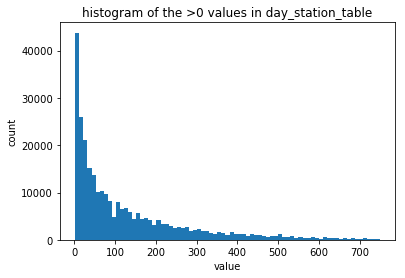

In [29]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]
NZ=NN[NN>0]
print shape(F),shape(NN),shape(NZ)

hist(NZ,bins=75);
title('histogram of the >0 values in day_station_table')
xlabel('value')
ylabel('count')

In [30]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

/Users/laurawilke/anaconda3/envs/py27_2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


total RMS                   =  104.148689838
RMS removing mean-by-station=  97.5359394591
RMS removing mean-by-day   =  73.5492120844


In [31]:
#Normalize rows of RT to have norm 1
Len=sqrt(np.nansum(tbl_minus_day**2,axis=1))
NRT=(tbl_minus_day.transpose()/Len).transpose()

In [32]:
K=5  # the number of time-shifts we consider
Middle=K/2 # the index (among K) of the zero-time-shift
n,m=RT.shape
TK=np.empty([n*K,m-K],dtype=numpy.float64)

#create the shifts
for i in range(K):
    TK[i::K,:]=NRT[:,i:-K+i]

#zero Nan entries and indicate them in a separate matrix
TKnan=np.isnan(TK)
TK[TKnan]=0
TK1nan=1-TKnan*1

TT=NRT[:,Middle:-Middle-1]
TTnan=np.isnan(TT)
TT1nan=1-TTnan*1
TT[TTnan]=0
print 'shape of sequence matrix (TT) %s, shape of matrix with %d shifts (TK) %s'%\
    (str(TT.shape),K,str(TK.shape))
#print sum(TK1nan,axis=1)
#print sum(TT1nan)

shape of sequence matrix (TT) (171, 44890), shape of matrix with 5 shifts (TK) (855, 44890)


In [33]:
Prod=np.dot(TK,TT.transpose())
print shape(Prod)
print sum(np.isnan(Prod.flatten()))

(855, 171)
0


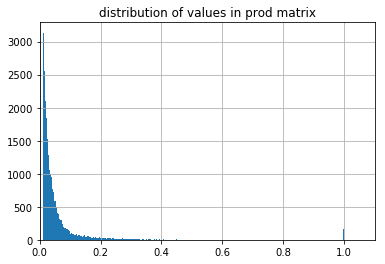

In [34]:
hist(Prod[Prod>0.01].flatten(),bins=300);
xlim([0.0,1.1])
title('distribution of values in prod matrix')
grid()
#showmat(ProdMean[:100,:100].transpose())

In [35]:
n,m

(171, 44895)

In [36]:
_shift=np.empty([n,n])
_max=np.empty([n,n])
for i in range(n):
    Slice=Prod[i*K:(i+1)*K,:]
    _shift[i,:]=np.argmax(Slice,axis=0)  #find best shift
    _max[i,:]=np.max(Slice,axis=0) #find max correlation

In [37]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.matshow(mat)

In [38]:
_max[_max>1.]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

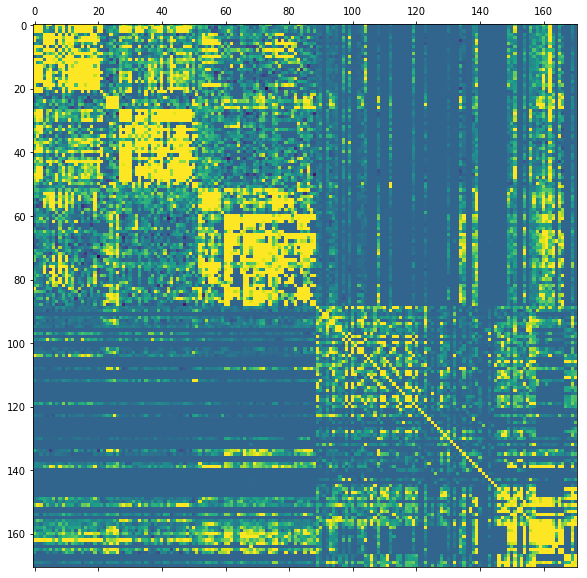

In [39]:
_max2=_max*10.
_max2[_max2>1.]=1.
showmat(_max2)
#showmat(_max*(_max>0.2))

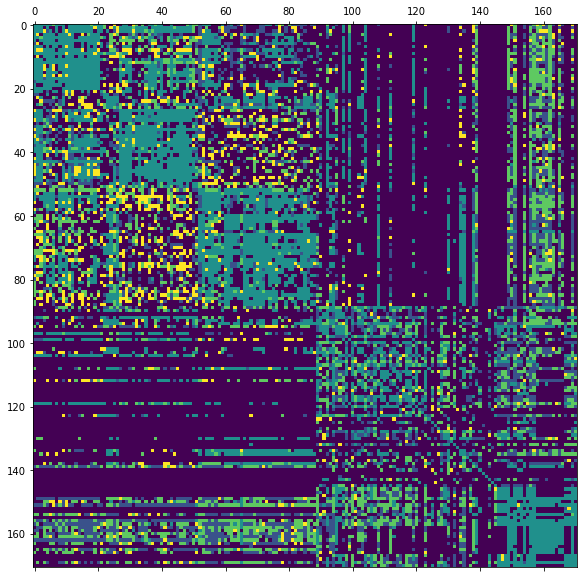

In [40]:
_Sshift=_shift*(_max>0.01)
showmat(_Sshift)

In [41]:
print min(_Sshift.flatten()),max(_Sshift.flatten())

0.0 4.0


[ 0.2003629   0.1807232   0.10506404  0.07502026  0.07272659  0.04725576
  0.0347558   0.03361019]
[ 0.12676282  0.11433744  0.06647046  0.04746277  0.04601165  0.02989711
  0.02198881  0.02126403]
[ 0.12676282  0.24110026  0.30757071  0.35503349  0.40104514  0.43094225
  0.45293106  0.47419509]


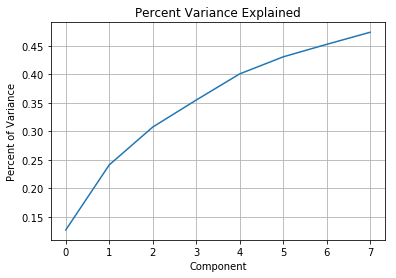

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8, svd_solver='full')
pca.fit(_max)     
print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
print (Var_explained)
print cumsum(Var_explained)
plot(cumsum(Var_explained))
title('Percent Variance Explained')
ylabel('Percent of Variance')
xlabel('Component')
grid()

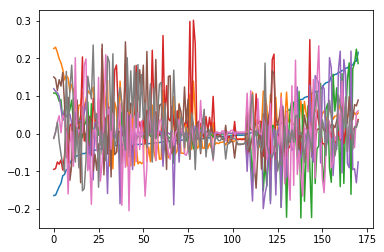

In [44]:
L=list(pca.components_.transpose())
X=sorted(L,key=lambda x:x[0]) 
plot(X);
#(key=lambda x:x[0])

In [45]:
len(pca.components_)

8

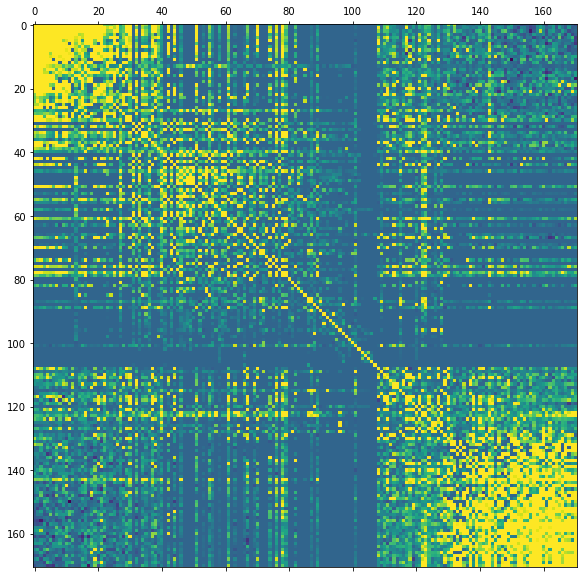

In [46]:
order=np.argsort(pca.components_[0,:])
_max_reord=_max[order,:]
_max_reord=_max_reord[:,order]
_max2=_max_reord*10.
_max2[_max2>1.]=1.
showmat(_max2)

In [47]:
len(_max2)

171

(8, 171)


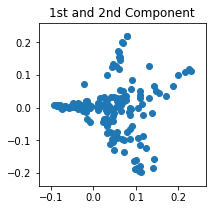

In [48]:
comp_=pca.components_
figure(figsize=(3,3))
print shape(comp_)
scatter(comp_[1,:],comp_[4,:]);
title('1st and 2nd Component')